In [22]:
%pip -q install timesfm jax seaborn

Note: you may need to restart the kernel to use updated packages.


In [24]:
import timesfm
# Prepare the Dataset
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/kboroz/TimeSeriesPrediction/refs/heads/main/Data/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

In [25]:
data = df
data['DATE']=pd.to_datetime(data['DATE'])
data.head()
print(len(data))

397


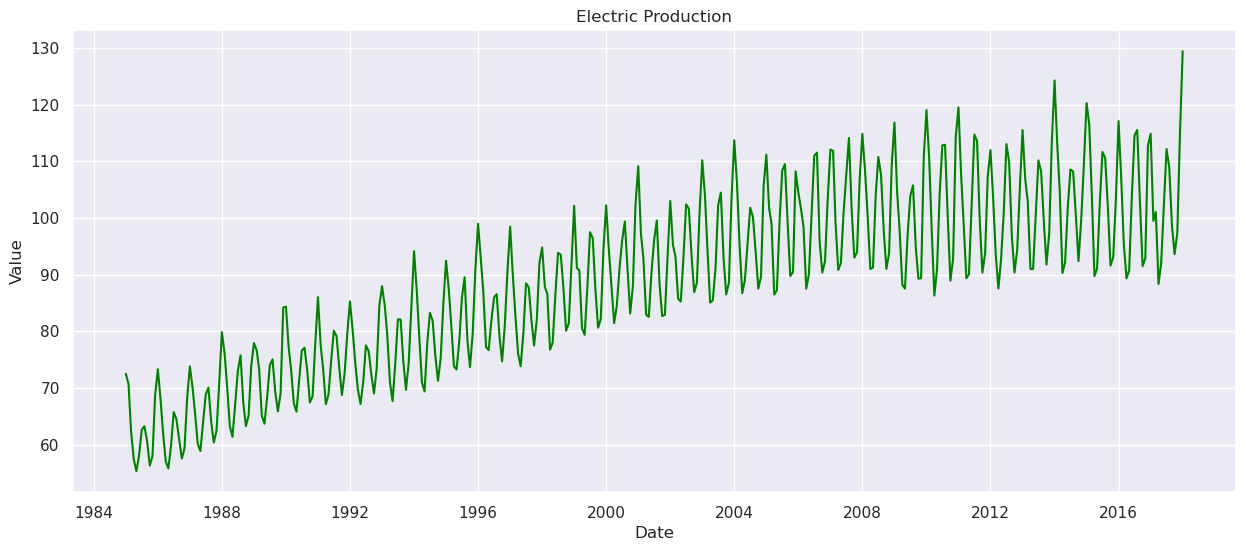

In [26]:
#Let's Visualise the Datas
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Settings the warnings to be ignored
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="DATE", y='Value', data=data, color='green')
plt.title('Electric Production')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

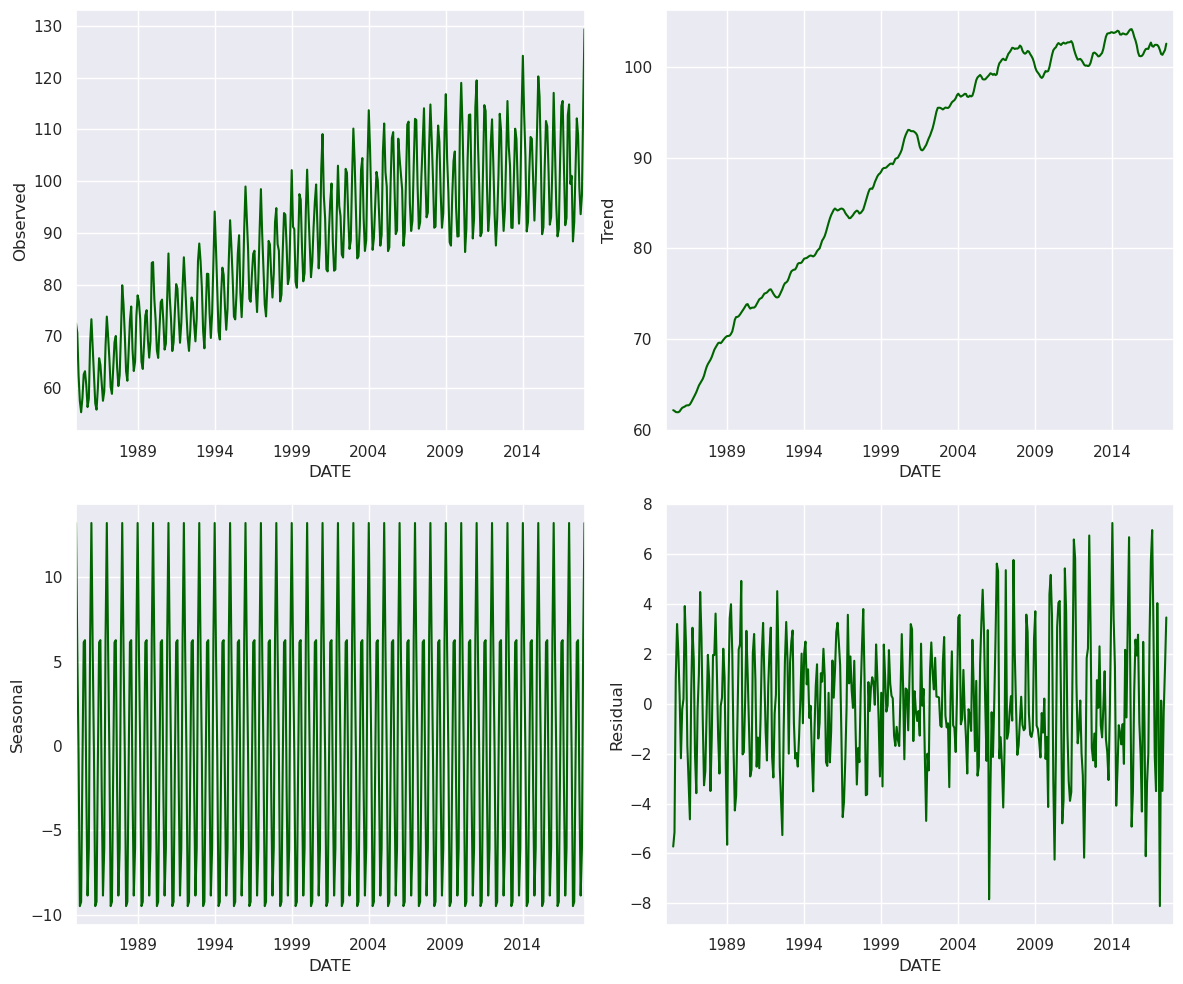

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Set index to DATE and decompose the data
data.set_index("DATE", inplace=True)
result = seasonal_decompose(data['Value'])
# Create a 2x2 grid for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
result.observed.plot(ax=ax1, color='darkgreen')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, color='darkgreen')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, color='darkgreen')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, color='darkgreen')
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()
# Adjust layout and show the plots
plt.tight_layout()
plt.show()
# Reset the index after plotting
data.reset_index(inplace=True)

In [28]:
df = pd.DataFrame({'unique_id':[1]*len(data),'ds': data["DATE"],
"y":data['Value']})

# Ensure the correct column names
df = pd.DataFrame({'unique_id': [1] * len(data), 'ds': data["DATE"], 'Value': data['Value']})

# Splitting into 94% and 6%
split_idx = int(len(df) * 0.94)
# Split the dataframe into train and test sets
# Splitting into 94% and 6%
x = (1-128/len(data['Value']))
split_idx = int(len(df) * x)
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)

(269, 3) (128, 3)


In [17]:
# Load TimesFM pretrained checkpoints with hyperparameters
tfm = timesfm.TimesFm(
  hparams = timesfm.TimesFmHparams(
    context_len=512, # max 512, can be shorter
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # ‘gpu’ when using GPU backend for fine-tuning
  ),
  checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
  )
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
# Generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,           # Input DataFrame containing the time-series data for training
    freq="M",                  # Frequency of the time-series data (e.g., 'M' for monthly, 'D' for daily)
    value_name="Value",        # Name of the column containing the values to be forecasted
    num_jobs=-1,               # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)

print(timesfm_forecast)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
     unique_id         ds     timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0            1 2016-01-31  111.178421     108.236183     109.313019   
1            1 2016-02-29  101.570984      97.993591      99.440323   
2            1 2016-03-31   88.067001      84.002602      85.532104   
3            1 2016-04-30   90.558311      86.627434      88.050674   
4            1 2016-05-31  103.427704      99.636940     100.993088   
..         ...        ...         ...            ...            ...   
123          1 2026-04-30   91.098930      83.810081      86.519943   
124          1 2026-05-31  104.945656      97.159729     100.485947   
125          1 2026-06-30  115.327316     108.008224     110.801651   
126          1 2026-07-31  112.526772     104.878479     107.795380   
127          1 2026-08-31   99.751747      92.558731      95.382553   

     timesfm-q-0.3  timesfm-q-0.4  timesfm-q-

In [19]:
timesfm_forecast.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2016-01-31,111.178421,108.236183,109.313019,109.819794,110.420410,111.178421,111.591827,112.050232,112.663712,113.859344
1,1,2016-02-29,101.570984,97.993591,99.440323,100.508072,101.124298,101.570984,102.404060,103.154472,103.849930,105.333923
2,1,2016-03-31,88.067001,84.002602,85.532104,86.320854,87.271324,88.067001,88.690422,89.401909,90.261162,91.849861
3,1,2016-04-30,90.558311,86.627434,88.050674,89.091103,89.706390,90.558311,91.359261,92.277596,93.223061,94.921402
4,1,2016-05-31,103.427704,99.636940,100.993088,101.951599,102.715332,103.427704,103.990051,105.233322,106.165039,107.505119


In [20]:
test_df.head()

,unique_id,ds,Value
373,1,2016-02-01,106.6688
374,1,2016-03-01,95.3548
375,1,2016-04-01,89.3254
376,1,2016-05-01,90.7369
377,1,2016-06-01,104.0375


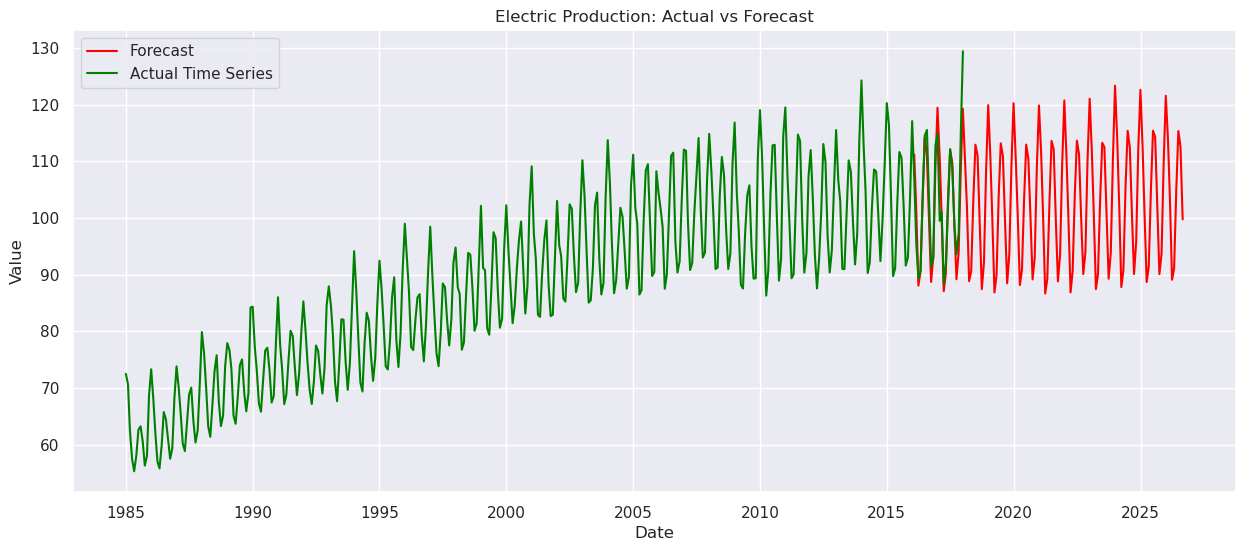

In [17]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Setting the warnings to be ignored
# Set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
# Plot actual timeseries data
sns.lineplot(x="ds", y='timesfm', data=timesfm_forecast, color='red', label='Forecast')
# Plot forecasted values
sns.lineplot(x="DATE", y='Value', data=data, color='green', label='Actual Time Series')
# Set plot title and labels
plt.title('Electric Production: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
# Show the legend
plt.legend()
# Display the plot
plt.show()